### Import modules

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization



### Load the train and test data and labels

In [4]:
#Load the splited and scaled train and test datasets
with open('train_test_data_from_preprocessing.pkl', 'rb') as f: 
#with open('train_test_data_from_featuretools.pkl', 'rb') as f:
#with open('train_test_data_from_proprocessing_plus_PCA.pkl', 'rb') as f:

    X_train, X_test, y_train, y_test  = pickle.load(f)
f.close()

In [5]:
X_train

array([[-0.22948083, -0.18337051, -0.40078842, ...,  0.31307138,
        -0.38953921,  1.12892245],
       [-0.58359088, -0.24233624, -0.58083903, ..., -0.80560901,
        -0.72967457, -0.89599049],
       [ 1.00077778, -0.3525324 ,  0.79954894, ..., -0.29300871,
        -0.55591917,  1.83652288],
       ...,
       [-0.21528398, -0.09552832, -0.40078842, ...,  0.34795806,
        -0.39913078, -0.31662474],
       [ 1.04296271,  3.48360111,  0.19938026, ...,  1.56261027,
         0.48741986, -0.5378388 ],
       [-0.12969725, -0.36743729, -0.40078842, ..., -0.41054333,
        -0.61469247, -1.00343423]])

In [6]:
#Get train and test feature and label shapes

print(f"X train shape is {X_train.shape}")
print(f"y train shape is {y_train.shape}")

print(f"X test shape is {X_test.shape}")
print(f"y test shape is {y_test.shape}")

X train shape is (54870, 10)
y train shape is (54870,)
X test shape is (13718, 10)
y test shape is (13718,)


In [7]:
print("Train data preview:")
print(X_train[:5, :])
print(y_train[:5])

print("Test data preview:")
print(X_test[:5, :])
print(y_test[:5])


Train data preview:
[[-0.22948083 -0.18337051 -0.40078842 -0.13725273  0.91416625 -0.38890813
   0.37981711  0.31307138 -0.38953921  1.12892245]
 [-0.58359088 -0.24233624 -0.58083903 -0.87732264  0.49386857  2.44576586
  -0.2478681  -0.80560901 -0.72967457 -0.89599049]
 [ 1.00077778 -0.3525324   0.79954894 -0.13725273  2.3698781   1.59021888
  -0.05458628 -0.29300871 -0.55591917  1.83652288]
 [ 0.99996653 -0.40356378 -1.60112578 -1.19449546 -0.54385753 -0.45170678
  -0.19472722 -0.41470217 -0.61483446 -0.34453527]
 [ 1.01740837  0.10994753 -1.0009571  -1.19449546 -0.53629182 -0.42214994
   0.14819313  0.0370503  -0.51132349 -0.43135029]]
id
98172    1
3299     0
20349    1
21314    0
48512    0
Name: cardio, dtype: int64
Test data preview:
[[-0.50773913 -0.55354677 -0.40078842 -0.13725273  2.34153675  2.61211461
  -0.19730738 -0.46801081 -0.62225061 -0.05246727]
 [ 0.12990233 -0.60880206 -0.40078842 -0.13725273 -0.5657923  -0.47902721
  -0.18149661 -0.43039188 -0.68537316  1.3845591 ]


### Model 1: Regularized Logistical Regression (Lasso, Ridge Regression and Elastic Net)

In [7]:
#grid search:
#the grid of parameters to search over

Cs = [0.001,0.01,0.1,1,10,100]
penalty = ['l1', 'l2', 'elasticnet']
#select sage as it works for all three type of penalties and is more efficient for large dataset
solver = ['saga'] 
#l1 ratio specific for elasticnet
l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

grid_params = [{
        'C': Cs,
        'penalty': ['l1', 'l2'],
        'solver': solver,
    
},
    {'C': Cs,
        'penalty': ['elasticnet'],
        'solver': solver,
        'l1_ratio': l1_ratio}
]

#grid search on the training dataset
lr_model = LogisticRegression()
lr_grid_cv = GridSearchCV(lr_model, param_grid=grid_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'penalty': ['l1', 'l2'], 'solver': ['saga']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                       0.9],
                          'penalty': ['elasticnet'], 'solver': ['saga']}])

In [8]:
#get the best parameters from Logistic regression
print(f"The best setting from grid search is {lr_grid_cv.best_params_}")

The best setting from grid search is {'C': 0.01, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'solver': 'saga'}


In [9]:
#using best setting to fit and cv on train data, predict on test data, to obtain confusion matrix and ROC curves
from sklearn.metrics import recall_score
scoring = ['precision_macro', 'recall_macro']
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5, scoring=scoring)
print(f"Precision of the cv results is {lr_best_cv_results['test_precision_macro']}")
print(f"Recall of the cv results is {lr_best_cv_results['test_recall_macro']}")

Precision of the cv results is [0.72710432 0.7304374  0.7270003  0.73010438 0.73172602]
Recall of the cv results is [0.72387327 0.72754839 0.72348782 0.72649139 0.72782926]


In [10]:
#prediction on test dataset


lr_best = lr_grid_cv.best_estimator_

lr_best.fit(X_train, y_train)

y_pred_lr  = lr_best.predict(X_test)




cnf_matrix= confusion_matrix(y_test,y_pred_lr)
print(f"With Elestic Net, the confusion matrix is:\n{cnf_matrix}")
Accuracy_lr=lr_best.score(X_test,y_test)

print(f"The overall accuracy of Elestic Net is {Accuracy_lr}")

With Elestic Net, the confusion matrix is:
[[5551 1445]
 [2240 4482]]
The overall accuracy of Elestic Net is 0.7313748359819215


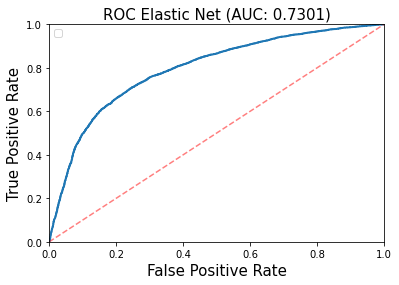

In [11]:
#Plot ROC curve and AUC score


auc_score = roc_auc_score(y_test, y_pred_lr)

RocCurveDisplay.from_estimator(lr_best, X_test, y_test, pos_label=1, linewidth=2.0)
plt.legend('')
plt.xlabel("False Positive Rate", size=15)
plt.ylabel("True Positive Rate", size=15)
plt.title(f"ROC Elastic Net (AUC: {round(auc_score, 4)})", size=15)
plt.plot([0, 1], [0, 1],'r--', alpha=0.5)
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()



### Model 2 Support Vector Machine

In [8]:
def svc_eval(C, gamma):
    svc = SVC(C=C, gamma=gamma, kernel='rbf', random_state=42, verbose=0)
                       
    
    
    #check on the roc_auc scores
    cv_score = cross_validate(svc, X_train, y_train, cv=5, scoring='roc_auc')
    
    
    return np.mean(cv_score['test_score'])

In [9]:
svcBO = BayesianOptimization(svc_eval, {'C': (0.001,1),
                                                'gamma': (0.01, 1)
                                                })

svcBO.maximize(n_iter=10, init_points=2)

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
|  1        |  0.7753   |  0.2435   |  0.6388   |
|  2        |  0.7727   |  0.3744   |  0.7359   |
|  3        |  0.7788   |  0.7012   |  0.3585   |
|  4        |  0.7709   |  0.2987   |  0.9052   |
|  5        |  0.7908   |  0.2515   |  0.03519  |
|  6        |  0.7806   |  0.001    |  0.01     |
|  7        |  0.791    |  0.2602   |  0.03194  |
|  8        |  0.7915   |  0.6028   |  0.01     |
|  9        |  0.7875   |  0.1575   |  0.1486   |
|  10       |  0.7917   |  0.9971   |  0.01078  |
|  11       |  0.7641   |  1.0      |  1.0      |
|  12       |  0.7916   |  0.829    |  0.01     |


In [10]:
print(f"Best setting for SVC from Bayesian optimization is {svcBO.max}")

Best setting for SVC from Bayesian optimization is {'target': 0.7917022644188817, 'params': {'C': 0.9971465218523063, 'gamma': 0.010778785737534278}}


In [11]:
scoring = ['precision_macro', 'recall_macro', 'roc_auc']

svc_best = SVC(C=svcBO.max['params']['C'], gamma=svcBO.max['params']['gamma'], kernel='rbf', random_state=42, verbose=0)

svc_best_cv_results = cross_validate(svc_best, X_train, y_train, cv=5, scoring=scoring)
print(f"Precision of the cv results is {svc_best_cv_results['test_precision_macro']}")
print(f"Recall of the cv results is {svc_best_cv_results['test_recall_macro']}")
print(f"AUC of the cv results is {svc_best_cv_results['test_roc_auc']}")

Precision of the cv results is [0.73039209 0.73310117 0.73313239 0.73047878 0.7357608 ]
Recall of the cv results is [0.72676404 0.72999471 0.7295988  0.72744605 0.73203809]
AUC of the cv results is [0.78777517 0.79141548 0.79083133 0.79313459 0.79535475]


In [12]:
#prediction on test dataset
from sklearn.metrics import confusion_matrix


svc_best.fit(X_train, y_train)

y_pred_svc  = svc_best.predict(X_test)




cnf_matrix= confusion_matrix(y_test,y_pred_svc)
print(f"With SVC, the confusion matrix is:\n{cnf_matrix}")
Accuracy_svc=svc_best.score(X_test,y_test)

print(f"The overall accuracy of SVC is {Accuracy_svc}")

With SVC, the confusion matrix is:
[[5608 1388]
 [2210 4512]]
The overall accuracy of SVC is 0.7377168683481558


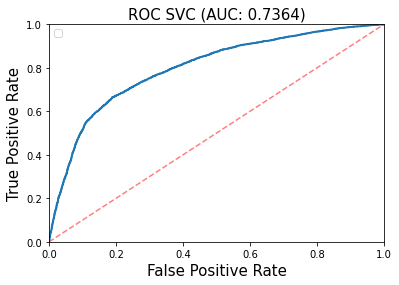

In [19]:
#Plot ROC curve and AUC score
from sklearn.metrics import roc_auc_score, RocCurveDisplay

auc_score = roc_auc_score(y_test, y_pred_svc)

RocCurveDisplay.from_estimator(svc_best, X_test, y_test, pos_label=1, linewidth=2.0)
plt.legend('')
plt.xlabel("False Positive Rate", size=15)
plt.ylabel("True Positive Rate", size=15)
plt.title(f"ROC SVC (AUC: {round(auc_score, 4)})", size=15)
plt.plot([0, 1], [0, 1],'r--', alpha=0.5)
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

### Model 3 Random Forest Classification

In [13]:
def rf_eval(n_estimator, max_feature, max_depth):

    
    rf = RandomForestClassifier(n_estimators=int(n_estimator), max_features = int(max_feature), criterion='entropy',
                               max_depth = int(max_depth), n_jobs=-1, random_state=42, verbose=0)
    
    cv_score = cross_validate(rf, X_train, y_train, cv=5)
    
    return np.mean(cv_score['test_score'])

In [14]:
rfBO = BayesianOptimization(rf_eval, {'n_estimator': (10, 1000),
                                                'max_feature': (1,10),
                                                'max_depth': (1,10)
                                                })

rfBO.maximize(n_iter=10, init_points=2)

|   iter    |  target   | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------
|  1        |  0.719    |  2.687    |  3.284    |  735.2    |
|  2        |  0.7322   |  6.921    |  5.238    |  257.1    |
|  3        |  0.7307   |  6.969    |  4.801    |  258.6    |
|  4        |  0.7307   |  6.751    |  8.278    |  247.5    |
|  5        |  0.7111   |  1.314    |  1.377    |  251.4    |
|  6        |  0.732    |  9.51     |  9.158    |  252.7    |
|  7        |  0.7311   |  7.913    |  9.755    |  258.5    |
|  8        |  0.7318   |  9.778    |  7.863    |  237.8    |
|  9        |  0.7293   |  5.576    |  9.942    |  229.7    |
|  10       |  0.7115   |  2.765    |  9.93     |  238.8    |
|  11       |  0.7323   |  10.0     |  4.5      |  232.5    |
|  12       |  0.7302   |  9.823    |  2.347    |  240.1    |


In [15]:
#get the best parameters
rfBO.max

{'target': 0.7323491889921633,
 'params': {'max_depth': 10.0,
  'max_feature': 4.5001986639942775,
  'n_estimator': 232.542435325987}}

In [16]:
rf_best = RandomForestClassifier(n_estimators=int(rfBO.max['params']['n_estimator']), \
max_features = int(rfBO.max['params']['max_feature']), criterion='entropy',
                               max_depth = int(rfBO.max['params']['max_depth']), n_jobs=-1, random_state=42, verbose=0)


scoring = ['precision_macro', 'recall_macro']
svc_best_cv_results = cross_validate(rf_best, X_train, y_train, cv=5, scoring=scoring)
print(f"Precision of the cv results is {svc_best_cv_results['test_precision_macro']}")
print(f"Recall of the cv results is {svc_best_cv_results['test_recall_macro']}")

Precision of the cv results is [0.73241476 0.7329477  0.73255094 0.73415818 0.73957406]
Recall of the cv results is [0.72955775 0.73110552 0.73064314 0.73178673 0.73665881]


In [18]:

rf_best.fit(X_train, y_train)

y_pred_rf  = rf_best.predict(X_test)



cnf_matrix= confusion_matrix(y_test,y_pred_rf)
print(f"With Random Forest, the confusion matrix is:\n{cnf_matrix}")
Accuracy_rf=rf_best.score(X_test,y_test)

print(f"The overall accuracy of Random Forest is {Accuracy_rf}")

With Random Forest, the confusion matrix is:
[[5516 1480]
 [2137 4585]]
The overall accuracy of Random Forest is 0.7363318267969091


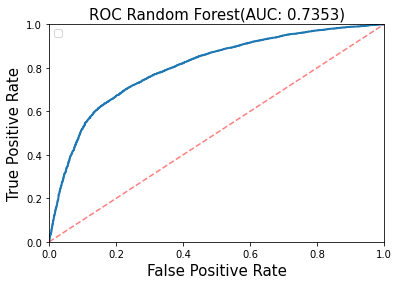

In [19]:
auc_score = roc_auc_score(y_test, y_pred_rf)

RocCurveDisplay.from_estimator(rf_best, X_test, y_test, pos_label=1, linewidth=2.0)
plt.legend('')
plt.xlabel("False Positive Rate", size=15)
plt.ylabel("True Positive Rate", size=15)
plt.title(f"ROC Random Forest(AUC: {round(auc_score, 4)})", size=15)
plt.plot([0, 1], [0, 1],'r--', alpha=0.5)
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()

### Method 4 XGBoost Classifier

In [20]:
def xgb_eval(n_estimator, learning_rate, max_depth, min_child_weight, gamma):
    xgb = XGBClassifier(n_estimators=int(n_estimator), max_depth= int(max_depth), learning_rate=learning_rate,
                        gamma=gamma, min_child_weight=min_child_weight, n_jobs=-1, random_state=42, verbosity=0,
                       use_label_encoder=False, objective="binary:logistic")
                       
    
    
    
    cv_score = cross_validate(xgb, X_train, y_train, cv=5)
    
    return np.mean(cv_score['test_score'])


In [22]:
xgbBO = BayesianOptimization(xgb_eval, {'n_estimator': (10, 1000),
                                       'learning_rate': (0.01, 2), 
                                       'min_child_weight': (1,6),
                                       'max_depth': (3,10),
                                       'gamma': (0,0.5)
                                       
                                                })

xgbBO.maximize(n_iter=100, init_points=4)

|   iter    |  target   |   gamma   | learni... | max_depth | min_ch... | n_esti... |
-------------------------------------------------------------------------------------
|  1        |  0.6909   |  0.288    |  0.6717   |  4.726    |  2.004    |  917.6    |
|  2        |  0.6521   |  0.2418   |  1.641    |  5.768    |  2.242    |  328.0    |
|  3        |  0.5251   |  0.3015   |  1.842    |  4.692    |  4.502    |  918.9    |
|  4        |  0.6898   |  0.2164   |  0.8752   |  7.038    |  1.564    |  92.69    |
|  5        |  0.7012   |  0.4788   |  0.7869   |  3.453    |  3.493    |  728.2    |
|  6        |  0.6919   |  0.3253   |  0.8545   |  3.515    |  2.422    |  952.4    |
|  7        |  0.5324   |  0.354    |  1.908    |  3.003    |  4.106    |  592.5    |
|  8        |  0.7219   |  0.1612   |  0.1357   |  5.117    |  1.52     |  900.4    |
|  9        |  0.7323   |  0.01025  |  0.1805   |  6.595    |  1.766    |  30.16    |
|  10       |  0.7113   |  0.2498   |  0.5405   |  3.5

In [23]:
#get the best parameters from xgboost regression
print(f"The best setting from Bayesian Optimizer for XGBoost is {xgbBO.max}")

The best setting from Bayesian Optimizer for XGBoost is {'target': 0.7331146345908511, 'params': {'gamma': 0.3862730924258478, 'learning_rate': 0.3410619927771585, 'max_depth': 3.8525906246490953, 'min_child_weight': 1.768311477824769, 'n_estimator': 41.874913679654526}}


In [24]:
xgb_best = XGBClassifier(n_estimators=int(xgbBO.max['params']['n_estimator']), \
learning_rate = xgbBO.max['params']['learning_rate'], 
gamma = xgbBO.max['params']['gamma'],
max_depth = int(xgbBO.max['params']['max_depth']),
min_child_weight = xgbBO.max['params']['min_child_weight'], \
                         n_jobs=-1, random_state=42, verbosity=0, \
                         use_label_encoder=False, objective="binary:logistic")
                              


scoring = ['precision_macro', 'recall_macro', 'roc_auc']
xgb_best_cv_results = cross_validate(xgb_best, X_train, y_train, cv=5, scoring=scoring)
print(f"Precision of the cv results is {xgb_best_cv_results['test_precision_macro']}")
print(f"Recall of the cv results is {xgb_best_cv_results['test_recall_macro']}")
print(f"AUC of the cv results is {xgb_best_cv_results['test_roc_auc']}")

Precision of the cv results is [0.73220962 0.73484909 0.73294175 0.73417727 0.73952941]
Recall of the cv results is [0.72967503 0.73332704 0.73151339 0.73218564 0.73706   ]
AUC of the cv results is [0.79650984 0.79517505 0.79728006 0.80068048 0.80051537]


In [26]:

xgb_best.fit(X_train, y_train)

y_pred_xgb  = xgb_best.predict(X_test)




cnf_matrix= confusion_matrix(y_test,y_pred_xgb)
print(f"With XGBoost, the confusion matrix is:\n{cnf_matrix}")
Accuracy_xgb=xgb_best.score(X_test,y_test)

print(f"The overall accuracy of XGBoost is {Accuracy_xgb}")

With XGBoost, the confusion matrix is:
[[5522 1474]
 [2103 4619]]
The overall accuracy of XGBoost is 0.7392477037469019


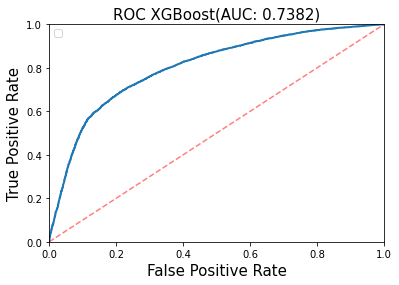

In [27]:
auc_score = roc_auc_score(y_test, y_pred_xgb)

RocCurveDisplay.from_estimator(xgb_best, X_test, y_test, pos_label=1, linewidth=2.0)
plt.legend('')
plt.xlabel("False Positive Rate", size=15)
plt.ylabel("True Positive Rate", size=15)
plt.title(f"ROC XGBoost(AUC: {round(auc_score, 4)})", size=15)
plt.plot([0, 1], [0, 1],'r--', alpha=0.5)
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()